In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

In [3]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [4]:
in_columns = ['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = ['0', '1', '2']
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)
MODEL_NAME = "XGB_apart_old"

In [5]:
BATCH_SIZE = int(1e4)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3

In [6]:
GANS_NAME = 'GAN_Kramer_dim3_bs1e4_n80-150_old_pid'
data_test_pid_a = np.array(pd.read_csv('./saved_dfs/{}{}.csv'.format(GANS_NAME, 'a')))
data_test_pid_b = np.array(pd.read_csv('./saved_dfs/{}{}.csv'.format(GANS_NAME, 'b')))
data_test_pid_c = np.array(pd.read_csv('./saved_dfs/{}{}.csv'.format(GANS_NAME, 'c')))
data_test_pid_d = np.array(pd.read_csv('./saved_dfs/{}{}.csv'.format(GANS_NAME, 'd')))
data_test_pid_e = np.array(pd.read_csv('./saved_dfs/{}{}.csv'.format(GANS_NAME, 'e')))
data_test_pid_f = np.array(pd.read_csv('./saved_dfs/{}{}.csv'.format(GANS_NAME, 'f')))

data_test = np.concatenate([data_test_pid_a, data_test_pid_b, data_test_pid_c, data_test_pid_d, data_test_pid_e, data_test_pid_f], axis=0)
data_test = pd.DataFrame(data_test, columns=out_columns+in_columns+["pid"])
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,0.136705,0.544656,-0.539618,0.835133,-1.10148,0,0,0,a
1,0.0197365,-0.114274,0.781342,-0.45038,-0.600841,-1000,-1000,0,a
2,0.0936931,-0.288508,0.805578,-0.464833,0.369165,-1000,-1000,0,a
3,0.00964214,0.257652,-0.492136,-0.307139,-0.264835,0,0,0,a
4,0.0173749,0.0636587,0.77309,-0.494985,-0.153744,-1000,-1000,0,a


In [7]:
np.unique(data_test["pid"], return_counts=True)

(array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object),
 array([39759, 39759, 39759, 39759, 39759, 39759]))

In [8]:
aux = pd.read_csv("./LHCb_PID_Compression/aux_test_old.csv")
aux.head()

,Unnamed: 0,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,pid
0,806680,0.284772,0.223544,0.259309,-0.146963,-0.060651,0.002035,0.202037,0.259122,0.259099,0.25913,0.214215,0.0,-0.005001,0.000157,0.000243,f
1,1433017,0.284772,0.223544,0.259309,-0.001203,0.151479,0.088446,0.202037,0.259122,0.259099,0.25913,0.584757,0.0,-0.040925,-0.000202,-0.000117,b
2,2233113,0.284772,0.223544,0.259309,-0.073936,0.080769,-0.064423,0.202037,0.259122,0.259099,0.25913,-0.161087,0.0,-0.017079,-0.000268,-0.000267,b
3,2013487,-1.000000,0.223544,0.259309,0.050440,0.151479,-0.082189,-0.196945,0.259122,0.259099,0.25913,-0.150745,0.0,0.150000,0.000073,-0.000297,b
4,2532583,0.284772,0.223544,0.259309,0.015057,-0.202071,0.023196,0.069043,0.259122,0.259099,0.25913,0.269076,0.0,0.066359,-0.000093,-0.000249,b


In [9]:
def split(data):
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    return data_train, data_val, data_test

In [10]:
data_all_pids = pd.read_csv("./LHCb_PID_Compression/df_old_encoded_ratio10_3.csv").drop('Unnamed: 0', axis=1)

In [11]:
data_all_pids.head()

,0,1,2,pid,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0
0,0.141307,-0.561677,-0.335716,f,14007.96,3.544102,1.0,1.0,1.0
1,0.757386,-0.171407,-0.786594,b,6828.52,3.352467,1.0,1.0,1.0
2,0.845820,-0.304628,-0.693679,b,5499.62,3.479671,1.0,1.0,1.0
3,0.794917,-0.476573,-0.658242,b,12328.97,4.370947,1.0,1.0,-999.0
4,0.641607,-0.117792,-0.647881,b,8997.15,3.924770,1.0,1.0,1.0


In [12]:
data_all_pids_aux = data_all_pids.copy()
for column in aux.columns:
    data_all_pids_aux[column] = np.array(aux[column])

In [13]:
data_all_pids_aux.head()

,0,1,2,pid,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,Unnamed: 0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux8
0,0.141307,-0.561677,-0.335716,f,0.000157,-0.005001,0.223544,0.259309,0.284772,806680,-0.146963,-0.060651,0.002035,0.202037,0.259122,0.259099,0.25913,0.214215,0.0,0.000243
1,0.757386,-0.171407,-0.786594,b,-0.000202,-0.040925,0.223544,0.259309,0.284772,1433017,-0.001203,0.151479,0.088446,0.202037,0.259122,0.259099,0.25913,0.584757,0.0,-0.000117
2,0.845820,-0.304628,-0.693679,b,-0.000268,-0.017079,0.223544,0.259309,0.284772,2233113,-0.073936,0.080769,-0.064423,0.202037,0.259122,0.259099,0.25913,-0.161087,0.0,-0.000267
3,0.794917,-0.476573,-0.658242,b,0.000073,0.150000,0.223544,0.259309,-1.000000,2013487,0.050440,0.151479,-0.082189,-0.196945,0.259122,0.259099,0.25913,-0.150745,0.0,-0.000297
4,0.641607,-0.117792,-0.647881,b,-0.000093,0.066359,0.223544,0.259309,0.284772,2532583,0.015057,-0.202071,0.023196,0.069043,0.259122,0.259099,0.25913,0.269076,0.0,-0.000249


In [14]:
data_pid_aux = {}

for pid in ["a", "b", "c", "d", "e", "f"]:
    data_pid_aux[pid] = data_all_pids_aux[data_all_pids_aux.pid == pid]

In [15]:
data_test_aux = {}
for pid in ["a", "b", "c", "d", "e", "f"]:
    _, _, data_test_aux[pid] = split(data_pid_aux[pid])

In [16]:
data_test_aux["a"].head()

,0,1,2,pid,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,Unnamed: 0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux8
36858,0.094624,0.449051,-0.484450,a,0.000126,-0.255177,0.223544,0.259309,0.284772,2120367,0.104113,0.151479,0.089222,-0.063951,0.259122,0.259099,0.25913,-0.066916,0.0,0.002516
830688,0.131309,-0.164211,0.825308,a,-0.000413,-0.144607,-1.000000,-1.000000,0.284772,2725606,-0.113984,-0.484912,0.003764,0.202037,-1.000000,-1.000000,-1.00000,-0.305706,0.0,-0.000292
383259,0.134313,-0.168015,0.534009,a,-0.000419,0.069624,-1.000000,-1.000000,0.284772,3270434,-0.013794,0.010059,-0.098162,-0.263441,-1.000000,-1.000000,-1.00000,-0.073436,0.0,-0.000530
1866394,0.462526,0.213574,-0.481343,a,-0.000353,-0.070399,0.223544,0.259309,0.284772,1100094,0.016649,0.292899,0.025108,-0.063951,0.259122,0.259099,0.25913,-0.277674,0.0,-0.000297
468754,0.089452,-0.183059,0.796946,a,-0.000432,-0.045864,-1.000000,-1.000000,0.284772,2683593,-0.010652,-0.414202,-0.058645,0.135540,-1.000000,-1.000000,-1.00000,0.012283,0.0,-0.000461


In [17]:
for column in data_all_pids_aux.columns:
    if "aux" in column:
        data_test[column] = np.concatenate([data_test_aux[pid][column].values for pid in ["a", "b", "c", "d", "e", "f"]])

In [18]:
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux8
0,0.136705,0.544656,-0.539618,0.000126,-0.255177,0.223544,0.259309,0.284772,a,0.104113,0.151479,0.089222,-0.063951,0.259122,0.259099,0.25913,-0.066916,0.0,0.002516
1,0.0197365,-0.114274,0.781342,-0.000413,-0.144607,-1.000000,-1.000000,0.284772,a,-0.113984,-0.484912,0.003764,0.202037,-1.000000,-1.000000,-1.00000,-0.305706,0.0,-0.000292
2,0.0936931,-0.288508,0.805578,-0.000419,0.069624,-1.000000,-1.000000,0.284772,a,-0.013794,0.010059,-0.098162,-0.263441,-1.000000,-1.000000,-1.00000,-0.073436,0.0,-0.000530
3,0.00964214,0.257652,-0.492136,-0.000353,-0.070399,0.223544,0.259309,0.284772,a,0.016649,0.292899,0.025108,-0.063951,0.259122,0.259099,0.25913,-0.277674,0.0,-0.000297
4,0.0173749,0.0636587,0.77309,-0.000432,-0.045864,-1.000000,-1.000000,0.284772,a,-0.010652,-0.414202,-0.058645,0.135540,-1.000000,-1.000000,-1.00000,0.012283,0.0,-0.000461


In [19]:
aux_columns = ['S5aux0',
 'S3aux0',
 'S2aux0',
 'S0aux0',
 'S0aux1',
 'S0aux2',
 'S0aux3',
 'S2aux1',
 'S2aux2',
 'S2aux3',
 'S0aux4',
 'S0aux5',
 'S0aux6',
 'S0aux7',
 'S0aux8']

In [20]:
data_test_enc = data_test[out_columns]
data_test_aux = data_test[aux_columns]

## Decoding using Autoencoder

In [21]:
def create_autoencoder_aux(n_features, encoding_dim, n_aux_features=5, p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    
    
    x = keras.layers.concatenate([inputs, aux_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features, activation='tanh')(x)
        x = keras.layers.concatenate([x, aux_inputs])

    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    x = keras.layers.concatenate([x, aux_inputs])
    encoded = Dense(encoding_dim, activation='tanh', name='encoded')(x)

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs])
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    
    for i in range(n_layers - 1):
        x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * n_features, activation='tanh')(x)
        
    decoded = Dense(n_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model([inputs, aux_inputs], encoded, name="encoder")
    decoder = Model([input_encoded, aux_inputs], decoded, name="decoder")
    autoencoder = Model(
        [inputs, aux_inputs], decoder([encoder([inputs, aux_inputs]), aux_inputs]), name="autoencoder"
    )

    optimizer_adam = optimizers.Adam(lr=0.001)
    autoencoder.compile(loss='mse', optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

In [22]:
autoencoder, encoder, decoder = create_autoencoder_aux(
        35, 3, 
        n_aux_features=15, n_layers=4, thickness=6
    )

In [23]:
autoencoder.load_weights("./LHCb_PID_Compression/model_old_ratio10_{}.hdf5".format(3))

In [24]:
decoded_test = decoder.predict([data_test_enc, data_test_aux])

In [25]:
vars_list_input = ['S0x0','S0x1','S0x2','S0x3','S0x4','S3x0','S3x1','S2x0','S2x1','S2x2','S2x3','S0x5','S0x6',
 'S0x7','S0x8','S0x9','S0x10','S1x0','S1x1','S1x2','S1x3','S1x4','S1x5','S5x0','S4x0','S4x1','S4x2','S3x2','S4x3',
 'S4x4','S5x1','S5x2','S5x3','S5x4','S4x5']

In [26]:
scalers = {var: {} for var in vars_list_input}
for i, var in enumerate(vars_list_input):
    scalers[var]['std'] = joblib.load(os.path.join('./LHCb_PID_Compression/preprocessors', "scaler_std_"+var) + ".pkl")
    scalers[var]['max'] = joblib.load(os.path.join('./LHCb_PID_Compression/preprocessors', "scaler_max_"+var) + ".pkl")

In [27]:
decoded_unscaled = decoded_test.copy()
for i, var in enumerate(vars_list_input):
    decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(decoded_unscaled[:, i].reshape(-1, 1))
    ).reshape(-1)

## XGBoost for PID Classification

In [29]:
from helpers import *

In [30]:
le = LabelEncoder()
y_ = le.fit_transform(data_test["pid"].values)

In [31]:
X = decoded_unscaled
Y = y_

In [32]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [33]:
path_to_metrics = './metrics/'
metrics_dir_name = "GAN_XGB_old"

In [34]:
le.classes_

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object)

In [35]:
clf_name = "XGBoost_old_{}".format(9)
clf = xgb.XGBClassifier(nthread=-1, seed=111)
clf = joblib.load(os.path.join('./LHCb_PID_Compression/xgboost', clf_name) + ".pkl")

In [44]:
np.unique(clf.predict(X[:39759]), return_counts=True)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1, 2, 3, 4, 5]), array([29499,  2570,  4496,  1082,   773,  1339]))

In [36]:
np.unique(clf.predict(X[39759:39759*2]), return_counts=True)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1, 2, 3, 4, 5]), array([  636, 35432,   384,  2929,   166,   212]))

In [37]:
np.unique(clf.predict(X[39759*2:39759*3]), return_counts=True)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1, 2, 3, 4, 5]), array([ 3035,  1421, 30496,  3088,   811,   908]))

In [38]:
np.unique(clf.predict(X[39759*3:39759*4]), return_counts=True)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1, 2, 3, 4, 5]), array([ 1067,  5496,  2522, 29314,   907,   453]))

In [39]:
np.unique(clf.predict(X[39759*4:39759*5]), return_counts=True)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1, 2, 3, 4, 5]), array([ 2940,  1513,  2179,   734, 18236, 14157]))

In [40]:
np.unique(clf.predict(X[39759*5:39759*6]), return_counts=True)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1, 2, 3, 4, 5]), array([ 3392,  1303,  2348,   580,  5844, 26292]))

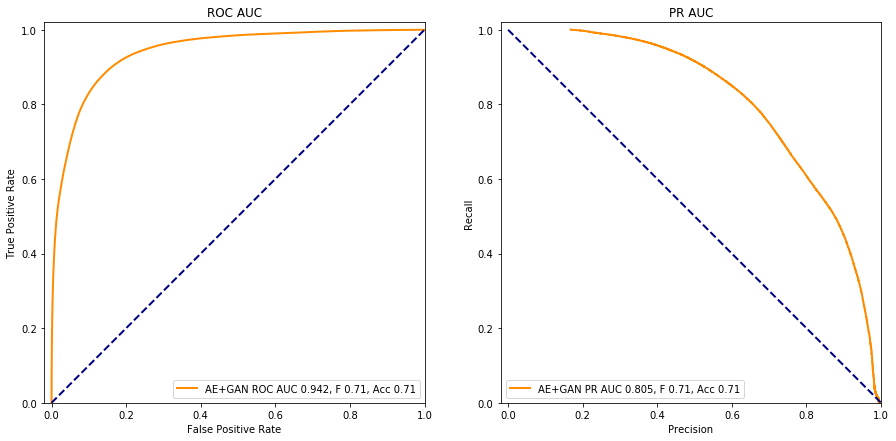

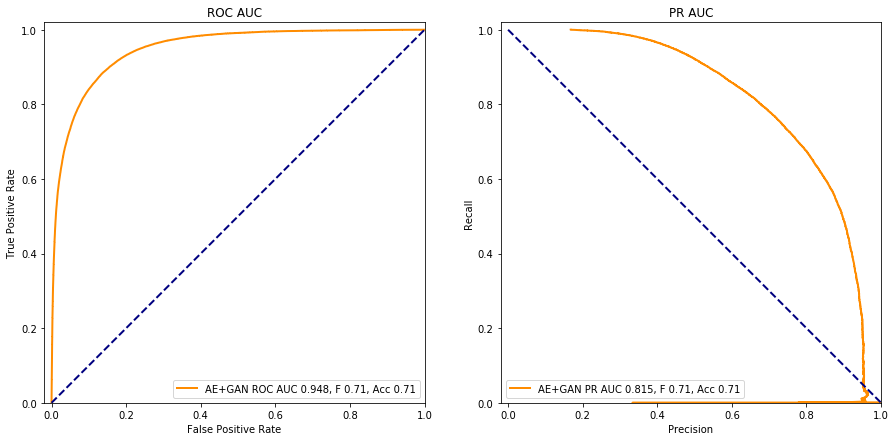

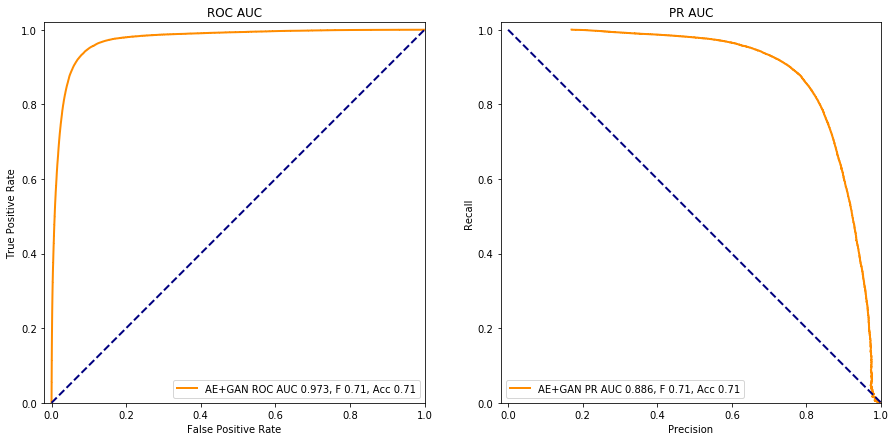

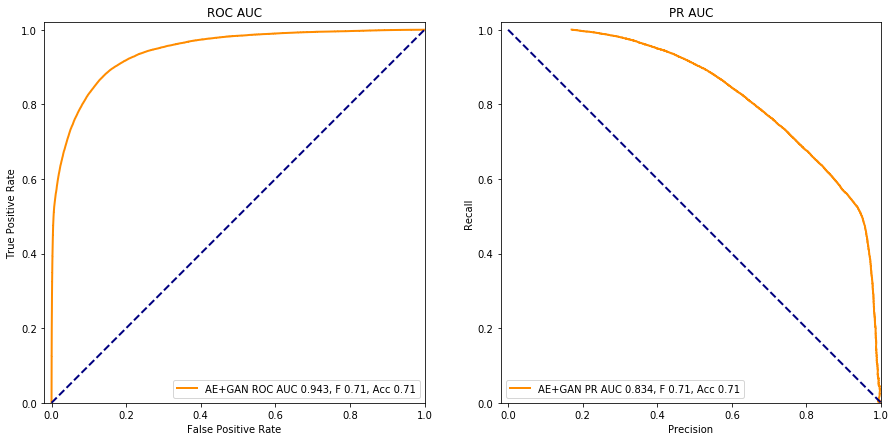

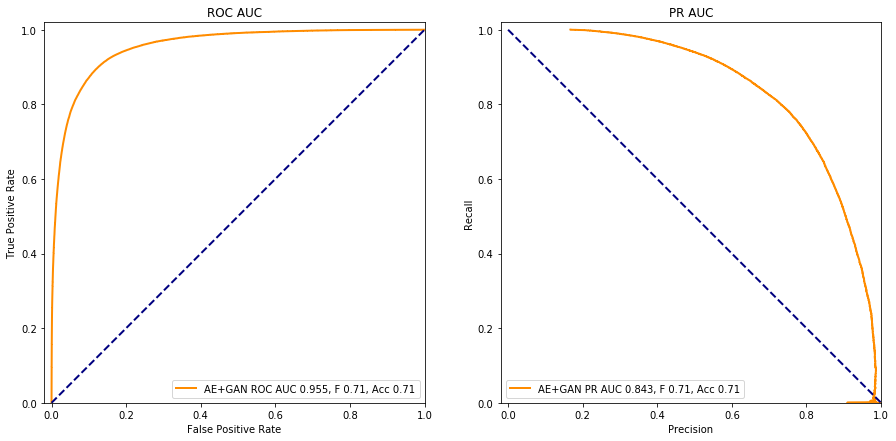

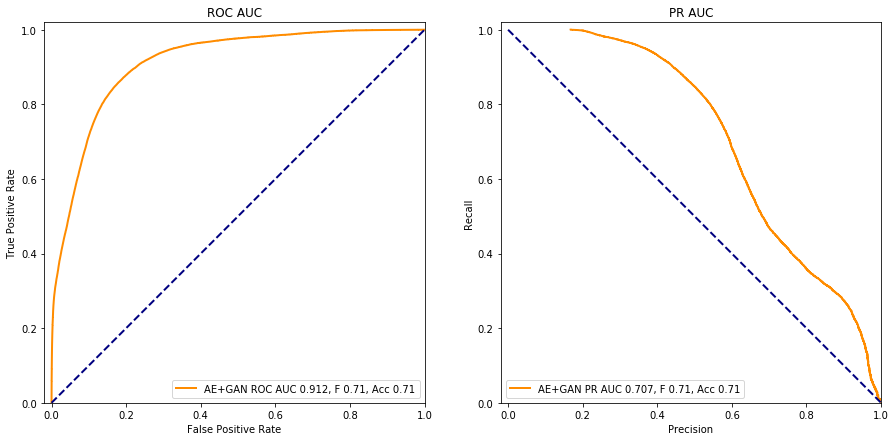

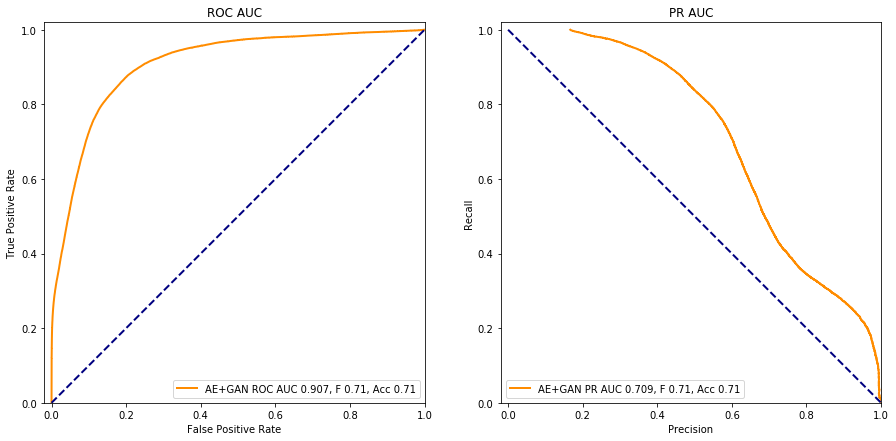

100%|██████████| 1/1 [00:24<00:00, 24.56s/it]


In [43]:
from tqdm import tqdm
for encoding_dim in tqdm(["AE+GAN"]):
    y_proba = clf.predict_proba(X)
    y = Y
    y_bin = label_binarize(y, classes=np.unique(y))
    y_pred = np.argmax(y_proba, axis=1)
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y):
        idx = np.where(y == pid_label)[0]
        cur_y = np.where(y == pid_label, np.ones_like(y), np.zeros_like(y))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
        metrics_dict['roc_auc'][encoding_dim][pid_label] = auc(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label])
        metrics_dict['pr_auc'][encoding_dim][pid_label] = average_precision_score(cur_y.ravel(), cur_y_proba.ravel())
        
#         metrics_dict['f_measure'][encoding_dim][pid_label] = f1_score(y, y_pred, average='micro')
#         metrics_dict['acc'][encoding_dim][pid_label] = accuracy_score(y, y_pred)
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='0', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='1', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='2', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='3', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='4', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='5', xlim=(-0.02, 1), ylim=(0, 1.02))
#     plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
#     plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))